The purpose of this project is to research the Phoenix, AZ market for Kayaks listed for sale on Craigslist.

In the past, I have ran a side-hustle (see an earlier project in my GitHub repository) where I bought and re-sold items online via eBay. But as this item is a much larger item, I am planning to sell online through sites like Craiglist where items sold are almost exclusively transferred in person.

Since I am new to the Phoenix area, I want to scrape Craiglist for the current listings to help in determing what is the appropriate pricing strategy for my kayak.

In [1]:
# Importing in each cell because of the kernel restarts.
import scrapy
import re
from scrapy.crawler import CrawlerProcess

class CLKayakSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of this class simultaneously.
    name = 'CLKS'
    
    # URL(s) to start with.
    start_urls = [
        'https://phoenix.craigslist.org/search/sss?query=kayak&sort=rel',
    ]
    
    # Use Xpath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every <listing> element on the page. //p selects all listing elements no matter where they are.
        for listing in response.xpath('//p'):
            
            # Yield a dictionary with the values we want.
            yield {
                # This is the code to choose what we want to extract. You can modify this with other Xpath expressions to extract
                # other information from the site.
                'title': listing.xpath('a[@class="result-title hdrlnk"]/text()').extract_first(),
                'date': listing.xpath('time[@class="result-date"]/text()').extract_first(),
                'price': listing.xpath('span/span[@class="result-price"]/text()').extract_first()
            }
            
        # Get the URL of the previous page.
        next_page = response.xpath('//div/div/span[@class="buttons"]/a[3][@href]').extract_first()
        
        # There are several pages here (322). We'll scrape the first 25. This finds the page number. The next segment of code
        # prevents us from going beyond page 25.
        pagenum = int(re.findall(r'\d+',next_page)[0])
        
        # Recursively call the spider to run on the next page, if it exists.
        if next_page is not None and pagenum < 26:
            next_page = response.urljoin(next_page)
            # Request the next page and recursively parse it the same way we did above.
            yield scrapy.Request(next_page, callback=self.parse)

# Tell the script how to run the crawler by passing in settings.
process = CrawlerProcess({
    'FEED_FORMAT': 'json',            # Store date in JSON format.
    'FEED_URI': 'clkdata.json',       # Name our storage file.
    'LOG_ENABLED': False,             # Turn off logging for now.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawlerTate (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True
})

# Start the crawler with our spider.
process.crawl(CLKayakSpider)
process.start()
print('Success!')

Success!


In [2]:
import pandas as pd

# Checking whether or not we got data from all 25 pages.
kayaks = pd.read_json('clkdata.json', orient='records')
print(kayaks.shape)
print(kayaks.head())

(120, 3)
     date price                                      title
0  Aug 28  None  Looking for a free kayak any shape please
1  Aug 28   $20                               kayak rental
2  Aug 28   $20                               kayak rental
3  Aug 28   $20                             Kayak for rent
4  Aug 28   $20                                      kayak


In [3]:
print(kayaks.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
date     120 non-null object
price    118 non-null object
title    120 non-null object
dtypes: object(3)
memory usage: 2.9+ KB
None


In [4]:
print(kayaks.describe(include='all'))

          date price          title
count      120   118            120
unique      15    33             76
top     Aug 28   $35  Kayak Rentals
freq        19    33             33


In [7]:
# Removing the two rows with null values in the price column.
kayaks = kayaks.dropna(how='any', axis=0)

In [8]:
print(kayaks.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 1 to 119
Data columns (total 3 columns):
date     118 non-null object
price    118 non-null object
title    118 non-null object
dtypes: object(3)
memory usage: 3.7+ KB
None


In [10]:
# Removing the $ sign from the price column.
kayaks['price'] = kayaks['price'].str.strip('$')

In [11]:
print(kayaks.head())

     date price                                   title
1  Aug 28    20                            kayak rental
2  Aug 28    20                            kayak rental
3  Aug 28    20                          Kayak for rent
4  Aug 28    20                                   kayak
5  Aug 28    35  Kayak Rentals and Paddle Board Rentals


In [12]:
# Converting price to integer in order to average price across listings.
kayaks['price'] = pd.to_numeric(kayaks.price)

In [13]:
print(kayaks.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 1 to 119
Data columns (total 3 columns):
date     118 non-null object
price    118 non-null int64
title    118 non-null object
dtypes: int64(1), object(2)
memory usage: 3.7+ KB
None


In [14]:
# We're going to start removing listings for rentals as the intent is to sell the kayak we have, thus in order to competitively
# price our kayak for sale we need to remove as many as the 'rental' listings as possible or we will end up underpricing ours.
kayaks.drop(kayaks[(kayaks.title == 'kayak rental')].index, inplace=True)

In [15]:
print(kayaks.describe(include='all'))

          date        price          title
count      115   115.000000            115
unique      15          NaN             73
top     Aug 28          NaN  Kayak Rentals
freq        16          NaN             33
mean       NaN   207.921739            NaN
std        NaN   459.591584            NaN
min        NaN     1.000000            NaN
25%        NaN    30.000000            NaN
50%        NaN    35.000000            NaN
75%        NaN   240.000000            NaN
max        NaN  3000.000000            NaN


In [16]:
kayaks.drop(kayaks[(kayaks.title == 'Kayak Rentals')].index, inplace=True)

In [17]:
print(kayaks.describe(include='all'))

          date        price  title
count       82    82.000000     82
unique      14          NaN     72
top     Aug 28          NaN  Kayak
freq        16          NaN      4
mean       NaN   279.829268    NaN
std        NaN   528.158501    NaN
min        NaN     1.000000    NaN
25%        NaN    35.000000    NaN
50%        NaN   140.000000    NaN
75%        NaN   250.000000    NaN
max        NaN  3000.000000    NaN


In [18]:
kayaks.drop(kayaks[(kayaks.title == 'Kayak for rent')].index, inplace=True)

In [19]:
print(kayaks.describe(include='all'))

          date        price  title
count       80    80.000000     80
unique      14          NaN     71
top     Aug 28          NaN  Kayak
freq        15          NaN      4
mean       NaN   286.325000    NaN
std        NaN   533.161879    NaN
min        NaN     1.000000    NaN
25%        NaN    35.000000    NaN
50%        NaN   150.000000    NaN
75%        NaN   250.000000    NaN
max        NaN  3000.000000    NaN


You can see each time we refresh .describe() the average or mean price goes up. We can also see the number of rows removed for 'rental' listings by the change in count. We started off with a significant drop but then slowed down so we may have cleaned up enough rows for now.

In [20]:
print(kayaks.head(25))

      date  price                                              title
4   Aug 28     20                                              kayak
5   Aug 28     35             Kayak Rentals and Paddle Board Rentals
6   Aug 28     35                                    Kayaks for rent
7   Aug 28     35                      Paddleboard and Kayak Rentals
8   Aug 28     35                                      KAYAK RENTALS
9   Aug 28     35                               PADDLE BOARD RENTALS
10  Aug 28    250                          Kayak Sale - equinox 10.4
11  Aug 28    250                                10 ft Pelican Kayak
12  Aug 28    300                      Emotion Spitfire Tandem Kayak
13  Aug 28    200  Sun Dolphin Journey 10 SS Sit On Angler / Fish...
14  Aug 28    190  Tamarack Angler 100 Fishing Kayak in Green (mi...
15  Aug 28    320  Lifetime Manta 100 Tandem 2 Person Kayak in Green
16  Aug 28    130  Lifetime Tahoma 100 Sit On Kayak in Lime Green...
17  Aug 28   1075                 

In [31]:
# Let's remove a few more entries in the title column.
kayaks.drop(kayaks[(kayaks.title == 'KAYAK RENTALS')].index, inplace=True)
kayaks.drop(kayaks[(kayaks.title == 'PADDLE BOARD RENTALS')].index, inplace=True)
kayaks.drop(kayaks[(kayaks.title == 'Kayak Tours')].index, inplace=True)
kayaks.drop(kayaks[(kayaks.title == 'Kayak Rentals and Paddle Board Rentals')].index, inplace=True)
kayaks.drop(kayaks[(kayaks.title == 'Paddleboard and Kayak Rentals')].index, inplace=True)
kayaks.drop(kayaks[(kayaks.title == 'Kayaks for rent')].index, inplace=True)
kayaks.drop(kayaks[(kayaks.title == 'Kayak rental')].index, inplace=True)
kayaks.drop(kayaks[(kayaks.title == 'Best Kayak & Paddle Board Rentals 24hr')].index, inplace=True)
kayaks.drop(kayaks[(kayaks.title == 'Best Kayak Rentals 24hr')].index, inplace=True)

In [32]:
print(kayaks.describe(include='all'))

          date        price  title
count       68    68.000000     68
unique      14          NaN     63
top     Aug 28          NaN  Kayak
freq        10          NaN      4
mean       NaN   330.676471    NaN
std        NaN   567.331208    NaN
min        NaN     1.000000    NaN
25%        NaN    35.000000    NaN
50%        NaN   200.000000    NaN
75%        NaN   300.000000    NaN
max        NaN  3000.000000    NaN


Ok, I think we're done with cleanup now. We only cleaned up 12 additional rows despite deleting several titles from the dataset. Our average prices is up to $330 now. One last clean-up we will perform below is to remove and price under $35.

In [34]:
kayaks.drop(kayaks[(kayaks.price < 35)].index, inplace=True)

In [35]:
print(kayaks.describe(include='all'))

          date        price  title
count       55    55.000000     55
unique      14          NaN     51
top     Aug 28          NaN  Kayak
freq         9          NaN      4
mean       NaN   403.818182    NaN
std        NaN   608.957795    NaN
min        NaN    35.000000    NaN
25%        NaN   140.000000    NaN
50%        NaN   250.000000    NaN
75%        NaN   360.000000    NaN
max        NaN  3000.000000    NaN


That had a decent impact! I'm glad we did it. And for the context we're considering, I still feel as though 55 listings is a good sample for us to consider when pricing our own kayak for sale.

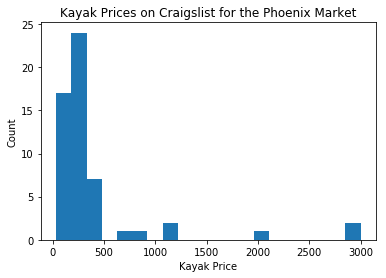

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(kayaks.price, bins=20)
plt.xlabel('Kayak Price')
plt.ylabel('Count')
plt.title('Kayak Prices on Craigslist for the Phoenix Market')

plt.show()

The vast majority of kayaks currently listed on Craigslist for sale are priced under $500, with an average listing price of $404 (rounding up).